## Attention


Attention = 注意力，从两个不同的主体开始。

### 直观理解

![](./resource/seq2seq.jpg)

From：https://arxiv.org/pdf/1703.03906.pdf

![](./resource/seq2seq2.gif)

From: https://github.com/google/seq2seq

### 如何计算

加性Attention，如（Bahdanau attention）：

$$
\boldsymbol{v}_a^{\top} \tanh \left(\boldsymbol{W}_{\mathbf{1}} \boldsymbol{h}_t+\boldsymbol{W}_{\mathbf{2}} \overline{\boldsymbol{h}}_s\right)
$$

乘性Attention，如（Luong attention）：

$$
\operatorname{score}\left(\boldsymbol{h}_{t}, \overline{\boldsymbol{h}}_{s}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}_{t}^{\top} \overline{\boldsymbol{h}}_{s} & \text { dot } \\
\boldsymbol{h}_{t}^{\top} \boldsymbol{W}_{a} \overline{\boldsymbol{h}}_{s} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{a}\left[\boldsymbol{h}_{t} ; \overline{\boldsymbol{h}}_{s}\right]\right) & \text { concat }
\end{array}\right.
$$

From: https://arxiv.org/pdf/1508.04025.pdf

## From Attention to SelfAttention

### Self Attention

"Attention is All You Need" 这篇论文提出了Multi-Head Self-Attention，是一种：Scaled Dot-Product Attention。

$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
$$

From：https://arxiv.org/pdf/1706.03762.pdf

### Scaled

Scaled 的目的是调节内积，使其结果不至于太大（太大的话softmax后就非0即1了，不够“soft”了）。

From: https://kexue.fm/archives/4765

### Multi-Head


Multi-Head可以理解为多个注意力模块，期望不同注意力模块“注意”到不一样的地方，类似于CNN的Kernel。

>Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions.

$$
\begin{aligned}
\operatorname{MultiHead}(Q, K, V) & =\operatorname{Concat}\left(\operatorname{head}_1, \ldots, \text { head }_{\mathrm{h}}\right) W^O \\
\text { where head }_{\mathrm{i}} & =\operatorname{Attention}\left(Q W_i^Q, K W_i^K, V W_i^V\right)
\end{aligned}
$$



From: https://arxiv.org/pdf/1706.03762.pdf

## 实践体验

In [ ]:
!pip list

In [ ]:
import matplotlib
print(matplotlib.__file__)
print(matplotlib.get_cachedir())
print(matplotlib.matplotlib_fname())

In [ ]:
# 依赖安装
!pip install torch torchvision torchaudio pandas scikit-learn jieba matplotlib

In [12]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F

In [13]:
from selfattention import SelfAttention

### 模型

我们只用一个核心的SelfAttention模块（可支持Single-Head或Multi-Head），来学习理解Attention机制。

In [14]:
class Model(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.emb = nn.Embedding(config.vocab_size, config.hidden_dim)
        self.attn = SelfAttention(config)
        self.fc = nn.Linear(config.hidden_dim, config.num_labels)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        h = self.emb(x)
        attn_score, h = self.attn(h)
        h = F.avg_pool1d(h.permute(0, 2, 1), seq_len, 1)
        h = h.squeeze(-1)
        logits = self.fc(h)
        return attn_score, logits

In [15]:
@dataclass
class Config:
    
    vocab_size: int = 5000 # 词表大小
    hidden_dim: int = 512
    num_heads: int = 16
    head_dim: int = 32
    dropout: float = 0.1
    
    num_labels: int = 2 # 标签数量，这里是二分类，所以2个标签
    
    max_seq_len: int = 512
    
    num_epochs: int = 10

In [16]:
config = Config(5000, 512, 16, 32, 0.1, 2)

In [17]:
model = Model(config)

In [18]:
x = torch.randint(0, 5000, (3, 30))
x.shape

torch.Size([3, 30])

In [19]:
attn, logits = model(x)
attn.shape, logits.shape

(torch.Size([3, 16, 30, 30]), torch.Size([3, 2]))

### 数据

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [21]:
file_path = "./data/ChnSentiCorp_htl_all.csv"

In [51]:
df = pd.read_csv(file_path)
df = df.dropna()
df.head(), df.shape

(   label                                             review
 0      1  距离川沙公路较近,但是公交指示不对,如果是"蔡陆线"的话,会非常麻烦.建议用别的路线.房间较...
 1      1                       商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
 2      1         早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
 3      1  宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
 4      1               CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风,
 (7765, 2))

In [52]:
df.label.value_counts()

label
1    5322
0    2443
Name: count, dtype: int64

数据不均衡，我们给它简单重采样一下。

In [49]:
df = pd.concat([df[df.label==1].sample(2500), df[df.label==0]])
df.shape

(4943, 2)

In [25]:
df.label.value_counts()

label
1    2500
0    2443
Name: count, dtype: int64

In [26]:
from tokenizer import Tokenizer

In [27]:
tokenizer = Tokenizer(config.vocab_size, config.max_seq_len)

In [28]:
tokenizer.build_vocab(df.review) # 构建词表

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.423 seconds.
Prefix dict has been built successfully.


In [29]:
tokenizer(["你好", "你好呀"])

tensor([[3265,    0],
        [3265,  914]])

In [30]:
def collate_batch(batch):
    label_list, text_list = [], []
    for v in batch:
        _label = v["label"]
        _text = v["text"]
        label_list.append(_label)
        text_list.append(_text)
    inputs = tokenizer(text_list)
    labels = torch.LongTensor(label_list)
    return inputs, labels

In [31]:
from dataset import Dataset

In [32]:
ds = Dataset()
ds.build(df, "review", "label")

In [33]:
len(ds), ds[0]

(4943, {'text': '酒店房间很大，比较卫生，但作为三星级酒店价格偏高，比广州北京的三星级酒店的价格高', 'label': 1})

In [34]:
train_ds, test_ds = train_test_split(ds, test_size=0.2)
train_ds, valid_ds = train_test_split(train_ds, test_size=0.1)
len(train_ds), len(valid_ds), len(test_ds)

(3558, 396, 989)

In [35]:
from torch.utils.data import DataLoader

In [57]:
BATCH_SIZE = 4

In [58]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_batch)
len(train_dl), len(valid_dl), len(test_dl)

(890, 99, 248)

In [59]:
for v in train_dl: break

In [60]:
v[0].shape, v[1].shape, v[0].dtype, v[1].dtype

(torch.Size([4, 213]), torch.Size([4]), torch.int64, torch.int64)

### 训练

In [42]:
from trainer import train, test

In [43]:
NUM_EPOCHS = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config(5000, 64, 1, 64, 0.1, 2)
model = Model(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
train(model, optimizer, train_dl, valid_dl, config)

test(model, test_dl)

Epoch [1/10]
Iter: 445,  Train Loss: 0.68,  Train Acc: 0.80,  Val Loss: 0.64,  Val Acc: 0.67
Epoch [2/10]
Iter: 890,  Train Loss: 0.36,  Train Acc: 0.90,  Val Loss: 0.52,  Val Acc: 0.77
Epoch [3/10]
Iter: 1335,  Train Loss: 0.31,  Train Acc: 0.90,  Val Loss: 0.48,  Val Acc: 0.79
Epoch [4/10]
Iter: 1780,  Train Loss: 0.26,  Train Acc: 1.00,  Val Loss: 0.46,  Val Acc: 0.80
Epoch [5/10]
Iter: 2225,  Train Loss: 0.23,  Train Acc: 1.00,  Val Loss: 0.44,  Val Acc: 0.81
Epoch [6/10]
Iter: 2670,  Train Loss: 0.21,  Train Acc: 1.00,  Val Loss: 0.43,  Val Acc: 0.82
Epoch [7/10]
Iter: 3115,  Train Loss: 0.19,  Train Acc: 1.00,  Val Loss: 0.42,  Val Acc: 0.83
Epoch [8/10]
Iter: 3560,  Train Loss: 0.19,  Train Acc: 0.90,  Val Loss: 0.41,  Val Acc: 0.83
Epoch [9/10]
Iter: 4005,  Train Loss: 0.18,  Train Acc: 0.90,  Val Loss: 0.41,  Val Acc: 0.84
Epoch [10/10]
Iter: 4450,  Train Loss: 0.21,  Train Acc: 0.90,  Val Loss: 0.42,  Val Acc: 0.84


0.8592037237001408

### 推理

In [40]:
from inference import infer, plot_attention
import numpy as np

In [ ]:
sample = np.random.choice(test_ds)
while len(sample["text"]) > 20:
    sample = np.random.choice(test_ds)

print(sample)

inp = sample["text"]
inputs = tokenizer(inp)
attn, prob = infer(model, inputs.to(device))
attn_prob = attn[0, 0, :, :].cpu().numpy()
tokens = tokenizer.tokenize(inp)
tokens, prob

In [ ]:
plot_attention(attn_prob, tokens, tokens)

In [ ]:
tokenizer.get_freq_of("不")

## 报错解决
### findfont font family simhei not found
这是因为matplotlib找不到中文字体

下载SimHei.tts文件

```
wget http://129.204.205.246/downloads/SimHei.ttf
```

复制到matplotlib的字体存放路径下`/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf`

```
cp SimHei.tts /usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf
```

不知道matplotlib包对应路径的小伙伴，可以用下面的代码查找
```

import matplotlib
print(matplotlib.__file__) # matplotlib包路径
print(matplotlib.get_cachedir()) # matplotlib缓存路径

```


清除python缓存字体
rm -rf /root/.cache/matplotlib/fontlist-v330.json

{'text': '便宜，物有所值。早餐：相对比较单调。', 'label': 1}


(['便宜', '，', '物有所值', '。', '早餐', '：', '相对', '比较', '单调', '。'], 1)

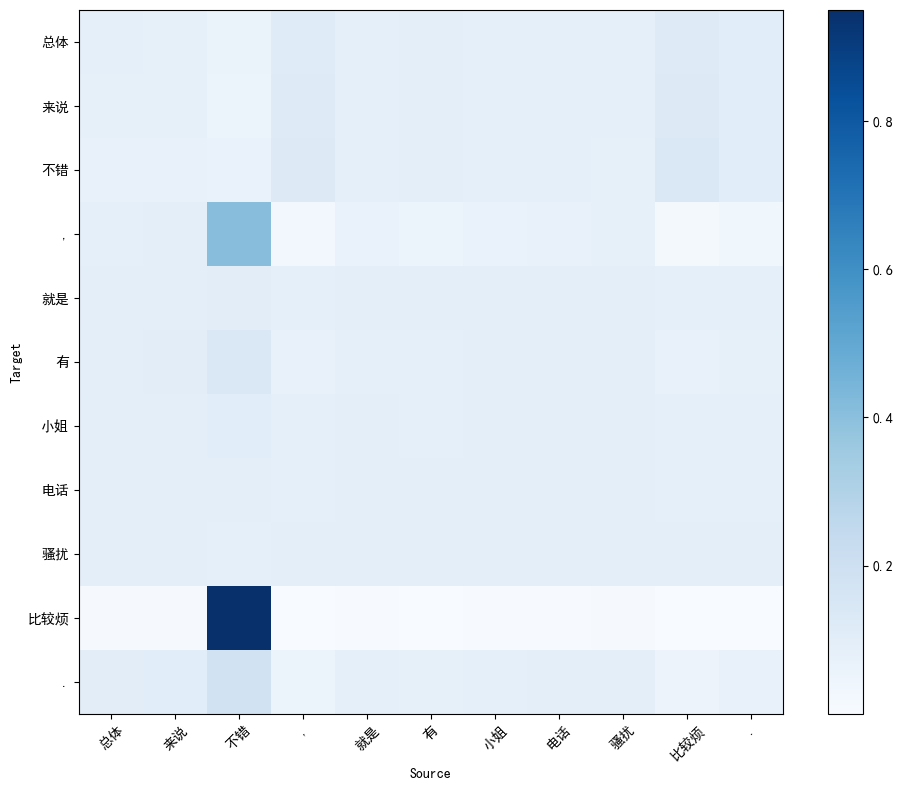

In [45]:
plot_attention(attn_prob, tokens, tokens)

In [50]:
tokenizer.get_freq_of("不")

2706

## 报错解决
### findfont font family simhei not found
这是因为matplotlib找不到中文字体

下载SimHei.tts文件

```
wget http://129.204.205.246/downloads/SimHei.ttf
```

复制到matplotlib的字体存放路径下`/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf`

```
cp SimHei.tts /usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf
```

不知道matplotlib包对应路径的小伙伴，可以用下面的代码查找
```

import matplotlib
print(matplotlib.__file__) # matplotlib包路径
print(matplotlib.get_cachedir()) # matplotlib缓存路径

```


清除python缓存字体
rm -rf /root/.cache/matplotlib/fontlist-v330.json